<a href="https://colab.research.google.com/github/rizkiar00/HMMPosTaggingIndonesia/blob/main/PosTagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mengambil dan Mengekstrak Dataset

https://github.com/kmkurn/id-pos-tagging/blob/master/data

In [2]:


!wget  https://github.com/kmkurn/id-pos-tagging/blob/master/data/dataset.tar.gz?raw=true
# open file
import tarfile

file = tarfile.open('dataset.tar.gz?raw=true')
  
# extracting file
file.extractall('dataset')
  
file.close()

--2021-04-03 07:23:03--  https://github.com/kmkurn/id-pos-tagging/blob/master/data/dataset.tar.gz?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/kmkurn/id-pos-tagging/raw/master/data/dataset.tar.gz [following]
--2021-04-03 07:23:03--  https://github.com/kmkurn/id-pos-tagging/raw/master/data/dataset.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kmkurn/id-pos-tagging/master/data/dataset.tar.gz [following]
--2021-04-03 07:23:04--  https://raw.githubusercontent.com/kmkurn/id-pos-tagging/master/data/dataset.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conn

In [3]:
# # Importing libraries
# import nltk
# import numpy as np
# import pandas as pd
# import random
# from sklearn.model_selection import train_test_split
# import pprint, time
 
# #download the treebank corpus from nltk
# nltk.download('treebank')
 
# #download the universal tagset from nltk
# nltk.download('universal_tagset')
 
# # reading the Treebank tagged sentences
# nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))
 
# #print the first two sentences along with tags
# print(nltk_data[:2])

## Mengambil Data Training

In [4]:
import csv
with open('/content/dataset/train.01.tsv', newline='') as f:
    reader = csv.reader(f,delimiter='\t',quoting=csv.QUOTE_NONE)
    train_set = list(reader)

print(train_set[0:40])
print(len(train_set))

[['Pemerintah', 'NN'], ['bahkan', 'RB'], ['telah', 'MD'], ['mencanangkan', 'VB'], ['dana', 'NN'], ['untuk', 'SC'], ['memicu', 'VB'], ['sektor', 'NN'], ['usaha', 'NN'], ['kecil', 'JJ'], ['dan', 'CC'], ['menengah', 'JJ'], ['UKM', 'NN'], ['tumbuh', 'VB'], ['lebih', 'RB'], ['baik', 'JJ'], [',', 'Z'], ['karena', 'SC'], ['sektor', 'NN'], ['ini', 'PR'], ['cukup', 'RB'], ['kuat', 'JJ'], ['dalam', 'IN'], ['krisis', 'JJ'], ['keuangan', 'NN'], ['pada', 'IN'], ['tahun', 'NN'], ['1997', 'CD'], ['lalu', 'CC'], [',', 'Z'], ['kata', 'VB'], ['-nya', 'PRP'], ['.', 'Z'], [], ['Gubernur', 'NNP'], ['Bank', 'NNP'], ['Indonesia', 'NNP'], ['Burhanudin', 'NNP'], ['Abdullah', 'NNP'], ['optimistis', 'JJ']]
191567


## Mengambil Data Testing

In [5]:
with open('/content/dataset/test.01.tsv', newline='') as f:
    reader = csv.reader(f,delimiter='\t')
    test_set = list(reader)
print(test_set[0:30])
print(len(test_set))

[['Pemerintah', 'NNP'], ['AS', 'NNP'], [',', 'Z'], ['pimpinan', 'NN'], ['Presiden', 'NNP'], ['George', 'NNP'], ['W.', 'NNP'], ['Bush', 'NNP'], [',', 'Z'], ['dalam', 'IN'], ['beberapa', 'CD'], ['pekan', 'NN'], ['belakangan', 'NN'], ['telah', 'MD'], ['meningkatkan', 'VB'], ['pendirian', 'NN'], ['-nya', 'PRP'], ['terhadap', 'IN'], ['Iran', 'NNP'], [',', 'Z'], ['yang', 'SC'], ['telah', 'MD'], ['dituduh', 'VB'], ['Barat', 'NNP'], ['secara', 'IN'], ['diam-diam', 'RB'], ['sedang', 'MD'], ['berusaha', 'VB'], ['membuat', 'VB'], ['bom atom', 'NN']]
53481


## Preprocessing


1.   Semua huruf jadi huruf kecil cth: LAsd -> lasd
2.   Semua angka menjadi 0 cth: dsaq123 -> dsaq0



In [6]:
def transform(w, lower=True, replace_digits=True):
    
    if lower:
        w = w.lower()
    if replace_digits:
        w = re.sub(r'\d+', '0', w)
    return w


## Membersihkan data yang kosong dan menyesuaikan format

In [7]:
# create list of train and test tagged words
# train_tagged_words = [ tup for sent in train_set for tup in sent ]
# test_tagged_words = [ tup for sent in test_set for tup in sent ]
# print(len(train_tagged_words))
# print(len(test_tagged_words))
import regex as re

def Remove(tuples):
    tuples = [t for t in tuples if t]
    return tuples

train_set = Remove(train_set)
test_set = Remove(test_set)

train_tagged_words = []
for alist in train_set:
    alist[0] = transform(alist[0])
    
    train_tagged_words.append(tuple(alist))

test_tagged_words = []
for alist in test_set:
    alist[0] = transform(alist[0])
    test_tagged_words.append(tuple(alist))
print(train_tagged_words[:5])
print(test_tagged_words[:5])

[('pemerintah', 'NN'), ('bahkan', 'RB'), ('telah', 'MD'), ('mencanangkan', 'VB'), ('dana', 'NN')]
[('pemerintah', 'NNP'), ('as', 'NNP'), (',', 'Z'), ('pimpinan', 'NN'), ('presiden', 'NNP')]


## Mengecek jenis kata dan vocabulary

In [8]:

tags = {tag for word,tag in train_tagged_words}
print(len(tags))
print(tags)
 
# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}
print(len(vocab))


23
{'CD', 'SYM', 'DT', 'RP', 'Z', 'PRP', 'CC', 'WH', 'RB', 'OD', 'SC', 'NN', 'NNP', 'IN', 'VB', 'PR', 'NND', 'NEG', 'X', 'JJ', 'UH', 'MD', 'FW'}
11680


## Fungsi untuk mengecek Peluang

In [10]:
# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)#total number of times the passed tag occurred in train_bag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
#now calculate the total number of times the passed word occurred as the passed tag.
    count_w_given_tag = len(w_given_tag_list)
 
     
    return (count_w_given_tag, count_tag)

# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

#Membuat Model Peluang HMM

In [13]:
import numpy as np
import pandas as pd

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

,CD,SYM,DT,RP,Z,PRP,CC,WH,RB,OD,SC,NN,NNP,IN,VB,PR,NND,NEG,X,JJ,UH,MD,FW
CD,0.261875,0.007054,0.000157,0.000235,0.171579,0.004546,0.033312,0.000000,0.005879,0.000157,0.024220,0.261013,0.028609,0.088729,0.056905,0.004781,0.025631,0.000549,0.001176,0.012620,0.000000,0.007446,0.003527
SYM,0.905672,0.008923,0.000637,0.000000,0.029318,0.000637,0.004461,0.000000,0.000000,0.000000,0.002549,0.010198,0.002549,0.018483,0.009560,0.000000,0.000000,0.000000,0.000000,0.005736,0.000000,0.000000,0.001275
DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.003610,0.000000,0.000000,0.000000,0.000000,0.000000,0.938628,0.010830,0.000000,0.018051,0.000000,0.000000,0.000000,0.000000,0.007220,0.000000,0.003610,0.018051
RP,0.043796,0.000000,0.000000,0.000000,0.072993,0.029197,0.007299,0.000000,0.087591,0.000000,0.182482,0.218978,0.014599,0.043796,0.102190,0.014599,0.007299,0.029197,0.000000,0.094891,0.000000,0.051095,0.000000
Z,0.045965,0.001962,0.004241,0.000106,0.008907,0.039656,0.072368,0.001537,0.013784,0.000318,0.105185,0.229615,0.181847,0.084403,0.154862,0.011346,0.008059,0.006362,0.001060,0.010762,0.000848,0.008271,0.008483
PRP,0.020895,0.008691,0.000185,0.000925,0.287352,0.003698,0.010725,0.000370,0.044933,0.000000,0.048262,0.114645,0.016272,0.092456,0.218750,0.005362,0.000370,0.029956,0.000925,0.017382,0.000000,0.076738,0.001109
CC,0.067268,0.007892,0.003006,0.001691,0.042841,0.018414,0.006389,0.001503,0.033822,0.000564,0.023675,0.372228,0.112176,0.044908,0.154453,0.011838,0.005261,0.016535,0.003382,0.041150,0.000000,0.021233,0.009771
WH,0.033333,0.000000,0.000000,0.122222,0.061111,0.088889,0.022222,0.000000,0.011111,0.000000,0.211111,0.272222,0.038889,0.005556,0.033333,0.016667,0.005556,0.011111,0.000000,0.027778,0.000000,0.016667,0.022222
RB,0.046491,0.007219,0.000289,0.002599,0.052267,0.019347,0.004909,0.000578,0.022235,0.000000,0.023968,0.056021,0.007508,0.076523,0.375108,0.004332,0.000578,0.013283,0.001155,0.213976,0.000000,0.066416,0.005198
OD,0.245841,0.003697,0.000000,0.000000,0.170055,0.022181,0.022181,0.000000,0.005545,0.003697,0.064695,0.116451,0.055453,0.109057,0.072089,0.027726,0.033272,0.001848,0.000000,0.014787,0.000000,0.014787,0.016636


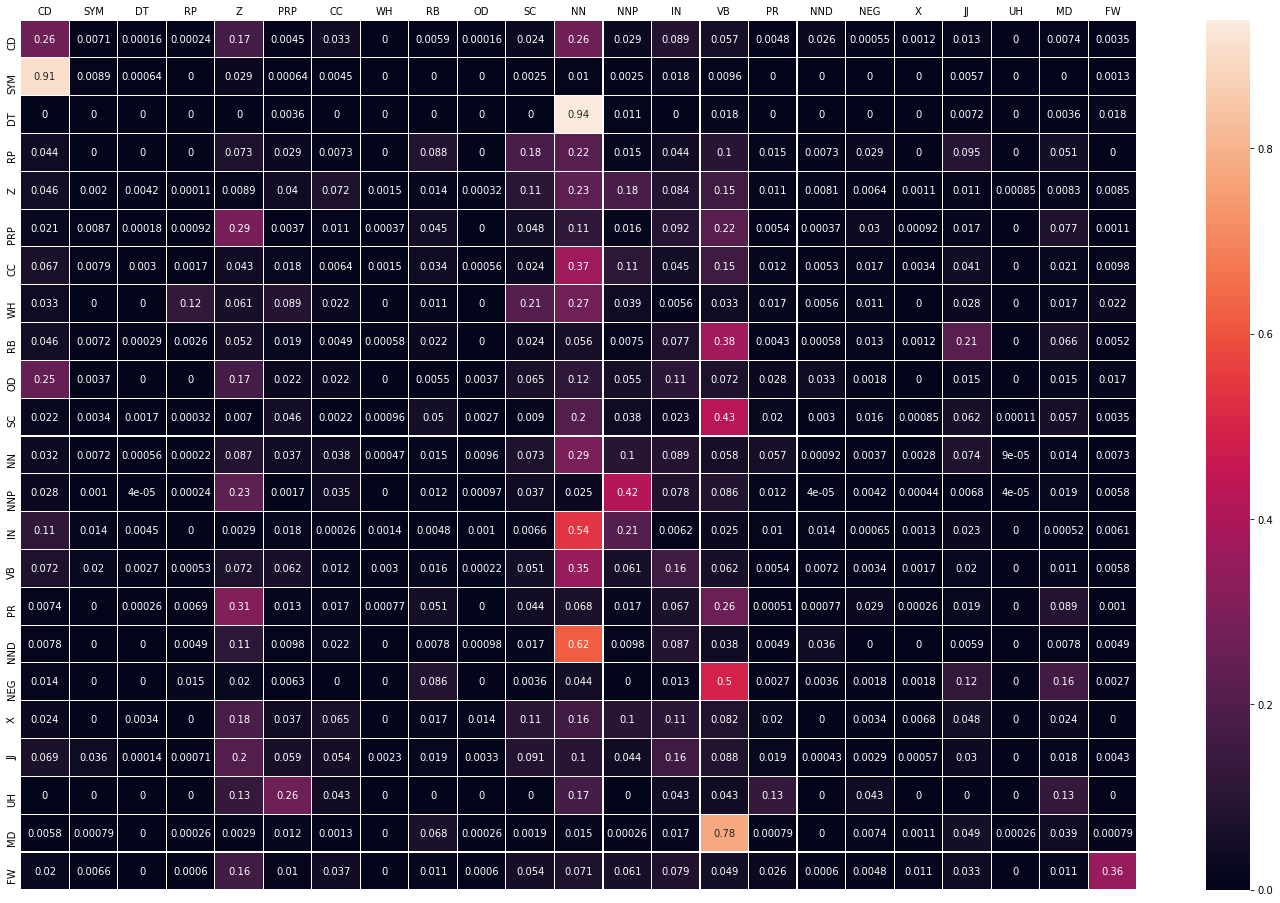

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (25,16))

ax = sns.heatmap(tags_df, linewidths=.1,annot=True)
ax.xaxis.tick_top()
ax.tick_params(length=0)

## Membuat Fungsi Viterbi

In [16]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['Z', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                 
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

## Testing untuk 10 kata pertama pada data test

In [18]:
import time
# list of 10 sents on which we test the model
test_run = test_set[0:10]
 
# list of tagged words
test_run_base = [tuple(sent) for sent in test_run]
 
# list of untagged words
test_tagged_words = [sent[0] for sent in test_run]

#Here We will only test 10 sentences to check the accuracy
#as testing the whole training set takes huge amount of time
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
 
print("Time taken in seconds For The First 10th Word: ", difference)
 
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy For The First 10th Word: ',accuracy*100)


Time taken in seconds For The First 10th Word:  7.930094480514526
Viterbi Algorithm Accuracy For The First 10th Word:  90.0


## Testing untuk semua data test 

(Dikarenakan terbatasnya google colab, maka testing dilakukan secara perlahan)

In [19]:
#Code to test all the test sentences
#(takes alot of time to run s0 we wont run it here)
# tagging the test sentences()
from pathlib import Path
import csv

test_tagged_words = [tuple(sent) for sent in test_set]
test_untagged_words = [sent[0] for sent in test_set]
#test_untagged_words

interval = 2000
filename = '/content/drive/MyDrive/output.csv'
if Path(filename).is_file():
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        listtagged_seq = list(reader)
    prevtagged_seq = []
    for i in listtagged_seq:
        prevtagged_seq.append(tuple(i))
    startidx = len(prevtagged_seq)
else:
    startidx = 0
    prevtagged_seq = []

endinterval = startidx + interval #(titik pada kalimat terakhir)
if endinterval > len(test_untagged_words):
    endinterval = len(test_untagged_words)-1


for i in range(endinterval,len(test_untagged_words)):
    if test_untagged_words[i] == '.':
        break
endinterval = i+1

if len(prevtagged_seq) < len(test_tagged_words):


    start = time.time()
    current = start

    tagged_seq = Viterbi(test_untagged_words[startidx:endinterval])
    end = time.time()
    difference = end-start
    wordcount = endinterval - startidx
    print("Finish at index: ", endinterval)
    print("Number of Word Prcessed: ", wordcount)
    print("Time taken in seconds: ", difference)


    # accuracy
    check = [i for i, j in zip(tagged_seq, test_tagged_words[startidx:endinterval]) if i == j] 
    
    accuracy = len(check)/len(tagged_seq)
    print('Viterbi Algorithm Accuracy: ',accuracy*100)



    prevtagged_seq.extend(tagged_seq)
    listouput = []
    for tuples in prevtagged_seq:
        listouput.append(list(tuples))
    with open(filename, "w") as f:
        writer = csv.writer(f)
        writer.writerows(listouput)
if len(prevtagged_seq) >= len(test_tagged_words):
    print("Part Of Speech Tagging has Been Finished")

Part Of Speech Tagging has Been Finished


## Hasil Akurasi dari prediksi POS Tagging pada semua data test



In [20]:
with open(filename, newline='') as f:
    reader = csv.reader(f)
    listtagged_seq = list(reader)
    prevtagged_seq = []
for i in listtagged_seq:
    prevtagged_seq.append(tuple(i))

check = [i for i, j in zip(prevtagged_seq, test_tagged_words[0:len(prevtagged_seq)]) if i == j] 
 
accuracy = len(check)/len(test_tagged_words[0:len(prevtagged_seq)])
print('Viterbi Algorithm Accuracy: ',accuracy*100)

Viterbi Algorithm Accuracy:  93.69985429820301


## NLTK untuk Word Tokenize

In [ ]:
import nltk
nltk.download('punkt')

## Testing untuk kalimat Inputan

In [23]:


print('Masukkan Kalimat yang akan di Post Tagging: ')
sentence = input()
sentence = nltk.word_tokenize(sentence)
sentence = list(map(transform, sentence))
taggedsentence = Viterbi(sentence)
print(taggedsentence)


Masukkan Kalimat yang akan di Post Tagging: 
Amerika tidak jadi membeli hand sanitizer seharga 5000000$ dari negara lain. Ledakan yang terjadi di prancis dikarenakan kelalaian petugas.
[('amerika', 'NNP'), ('tidak', 'NEG'), ('jadi', 'VB'), ('membeli', 'VB'), ('hand', 'CD'), ('sanitizer', 'CD'), ('seharga', 'NN'), ('0', 'CD'), ('$', 'SYM'), ('dari', 'IN'), ('negara', 'NN'), ('lain', 'JJ'), ('.', 'Z'), ('ledakan', 'NN'), ('yang', 'SC'), ('terjadi', 'VB'), ('di', 'IN'), ('prancis', 'NNP'), ('dikarenakan', 'VB'), ('kelalaian', 'NN'), ('petugas', 'NN'), ('.', 'Z')]
